In [32]:
import argparse
import os
import numpy as np

args = argparse.ArgumentParser()
args.add_argument('--mode', type=str, default='train')
args.add_argument('--pause', type=int, default=0)
args.add_argument('--iteration', type=str, default='0')

# User options
args.add_argument('--model', type=str, default='WordCNN')
args.add_argument('--normalizer', type=str, default='BasicNormalizer')
args.add_argument('--tokenizer', type=str, default='JamoTokenizer')
args.add_argument('--features', type=str, default='LengthFeatureExtractor')  # LengthFeatureExtractor_MovieActorFeaturesExtractor ...
args.add_argument('--dictionary', type=str, default='RandomDictionary')
args.add_argument('--use_gpu', type=bool, default=False)
args.add_argument('--output', type=int, default=1)
args.add_argument('--epochs', type=int, default=10)
args.add_argument('--batch_size', type=int, default=64)
args.add_argument('--vocabulary_size', type=int, default=50000)
args.add_argument('--embedding_size', type=int, default=16)
args.add_argument('--min_length', type=int, default=64)
args.add_argument('--max_length', type=int, default=300)
args.add_argument('--sort_dataset', action='store_true')
args.add_argument('--shuffle_dataset', action='store_true')
args.add_argument('--learning_rate', type=float, default=0.01)
args.add_argument('--lr_schedule', action='store_true')
args.add_argument('--print_every', type=int, default=1)
args.add_argument('--save_every', type=int, default=1)
config = args.parse_args([])

import argparse
import os
from os.path import dirname, abspath, join, exists
import numpy as np

import torch
from torch.autograd import Variable
from torch import nn, optim
from torch.utils.data import DataLoader

import models
import normalizers
import tokenizers
import feature_extractors
import dictionaries
from dataloader import load_data, collate_fn, Preprocessor, MovieReviewDataset
from trainers import Trainer
import utils


DATASET_PATH='./data/movie_review_phase1/'

Normalizer = getattr(normalizers, config.normalizer)
normalizer = Normalizer(config)

Tokenizer = getattr(tokenizers, config.tokenizer)
tokenizer = Tokenizer(config)

Dictionary = getattr(dictionaries, config.dictionary)
dictionary = Dictionary(tokenizer, config)

feature_extractor_list = []
for feature_name in config.features.split('_'):
    FeatureExtractor = getattr(feature_extractors, feature_name)
    feature_extractor = FeatureExtractor(config)
    feature_extractor_list.append((feature_name, feature_extractor))

preprocessor = Preprocessor(config, normalizer, tokenizer, feature_extractor_list, dictionary)
print("Number of features:", preprocessor.n_features)

DATASET_PATH='./data/movie_review_phase1/'

train_data, val_data = load_data(DATASET_PATH, val_size=0.1)

for feature_name, feature_extractor in preprocessor.feature_extractors:
    feature_extractor.fit(train_data)

preprocessor.dictionary.build_dictionary(train_data)

import torch
from torch import nn
from torch.autograd import Variable

train_dataset = MovieReviewDataset(train_data, preprocessor, sort=config.sort_dataset, min_length=config.min_length, max_length=config.max_length)
val_dataset = MovieReviewDataset(val_data, preprocessor, sort=config.sort_dataset, min_length=config.min_length, max_length=config.max_length)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=config.batch_size, shuffle=config.shuffle_dataset, collate_fn=collate_fn,
                          num_workers=1)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=config.batch_size, shuffle=True,
                              collate_fn=collate_fn, num_workers=1)


Number of features: 2
Total number of unique tokens: 9023


In [33]:
class LSTMClassifier(nn.Module):
    """
    TODO
    수렴하는거 보고나서 bidirectional로 전환.
    """

    def __init__(self, config):
        super(LSTMClassifier, self).__init__()
        ###########################################
        self.hidden_dim = 100
        self.label_size = 10
        self.layer_number = 2
        self.batch_size = 100
        ###########################################
        self.word_embeddings = nn.Embedding(config.vocabulary_size, config.embedding_size)
        self.lstm = nn.LSTM(config.embedding_size, self.hidden_dim,self.layer_number)
        self.B1 = nn.BatchNorm1d(self.hidden_dim)
        self.hidden2label = nn.Linear(self.hidden_dim, self.label_size)
        self.B2 = nn.BatchNorm1d(self.label_size)
        self.label2score = nn.Linear(self.label_size,1)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.layer_number, self.batch_size, self.hidden_dim)),
                autograd.Variable(torch.zeros(self.layer_number, self.batch_size, self.hidden_dim)))

    def forward(self, reviews,features):
        embeds = self.word_embeddings(reviews)
        x = embeds.transpose(0,1)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y = self.B1(lstm_out[-1])
        y  = self.hidden2label(lstm_out[-1])
        y = self.B2(y)
        y = self.label2score(y)
#        log_probs = F.log_softmax(y,dim=1)
        return y

In [53]:
## embedding 넣을 때
# model.word_embeddings.weight.data
sys.path.append('./models/')

import CNN_LSTM

import imp

imp.reload(CNN_LSTM)

model = CNN_LSTM.CNN_LSTM(config)

In [47]:
#model.batch_size = len(Variable(target).data)
#model.init_hidden()
#model(Variable(review),Variable(feature))

In [57]:
trainable_params = [p for p in model.parameters() if p.requires_grad]

In [63]:
trainable_params == filter(lambda p: p.requires_grad, model.parameters())

False

In [64]:
filter(lambda p: p.requires_grad, model.parameters())

In [58]:
loss_function = nn.MSELoss()
#optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 3e-2)
optimizer = optim.Adam(params = trainable_params, lr = 3e-2)

In [18]:
model(review,feature)

RuntimeError: Given groups=1, weight[64, 16, 3], so expected input[64, 100, 73] to have 16 channels, but got 100 channels instead

In [33]:
model = models.VDCNN(config,0)
loss_function = nn.MSELoss()
#optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 3e-2)
optimizer = optim.Adam(model.parameters(), lr = 3e-3)

In [39]:
model.load_state_dict(torch.load('./VDCNN.pth'))

RuntimeError: cuda runtime error (35) : CUDA driver version is insufficient for CUDA runtime version at torch/csrc/cuda/Module.cpp:107

In [38]:
EPOCH = 5
for i in range(EPOCH):
#    model.train()
    avg_loss = 0.0
    count = 0
    truth_res = []
    pred_res = []
    for review, feature, target in val_dataloader:
        review = Variable(review)
        feature = Variable(feature)
        target = Variable(target)
        truth_res += list(target.data)
        pred_label = model(review,feature)
#        pred_label = pred.data.max(1)[1].numpy()
        model.zero_grad()
        loss = loss_function(pred_label, target)
        avg_loss += loss.data[0]
        count += 1
        if count % 100 == 0:
            print('epoch: %d iterations: %d loss :%g' % (i, count*config.batch_size, loss.data[0]))
        loss.backward()
        optimizer.step()
        if count % 1000 == 0:
            print(pred_label)
    avg_loss /= len(train_dataloader)
    print('epoch: %d done!\ntrain avg_loss:%g'%(i, avg_loss))

epoch: 0 iterations: 6400 loss :9.94663
epoch: 0 iterations: 12800 loss :8.77449
epoch: 0 iterations: 19200 loss :7.57094
epoch: 0 iterations: 25600 loss :8.85103
epoch: 0 iterations: 32000 loss :8.83522
epoch: 0 iterations: 38400 loss :5.75671
epoch: 0 iterations: 44800 loss :8.75988
epoch: 0 iterations: 51200 loss :10.1731
epoch: 0 done!
train avg_loss:0.903508
epoch: 1 iterations: 6400 loss :7.66268
epoch: 1 iterations: 12800 loss :8.47006
epoch: 1 iterations: 19200 loss :7.86976
epoch: 1 iterations: 25600 loss :7.19407
epoch: 1 iterations: 32000 loss :6.5842
epoch: 1 iterations: 38400 loss :8.03939
epoch: 1 iterations: 44800 loss :8.49249
epoch: 1 iterations: 51200 loss :7.23349
epoch: 1 done!
train avg_loss:0.802736
epoch: 2 iterations: 6400 loss :8.31007
epoch: 2 iterations: 12800 loss :6.49606
epoch: 2 iterations: 19200 loss :5.95904
epoch: 2 iterations: 25600 loss :5.7564
epoch: 2 iterations: 32000 loss :5.35195
epoch: 2 iterations: 38400 loss :4.60756
epoch: 2 iterations: 4480

Process Process-14:
Traceback (most recent call last):
  File "/home/mappiness/anaconda3/envs/torch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/mappiness/anaconda3/envs/torch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mappiness/anaconda3/envs/torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/mappiness/anaconda3/envs/torch/lib/python3.6/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/home/mappiness/anaconda3/envs/torch/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/mappiness/anaconda3/envs/torch/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/mappiness/anaconda3/envs/torch/lib/python3.6/multiprocessing/con

KeyboardInterrupt: 

In [ ]:
model.lo

In [36]:
config.batch_size

64

In [39]:
loss.backward(retain_graph=True)

In [38]:
model(review,feature)

Variable containing:
 0.2483
 0.1171
 0.0917
 0.0916
 0.1298
 0.0916
 0.0916
 0.0917
 0.0917
 0.0916
 0.0916
 0.0916
 0.0924
 0.0916
 0.0933
 0.0920
 0.0916
 0.1797
 0.0916
 0.0917
 0.0917
 0.0920
 0.0916
 0.0926
 0.0916
 0.1760
 0.0917
 0.0916
 0.0916
 0.1697
 0.0995
 0.0917
 0.1660
 0.0916
 0.0923
 0.0932
 0.0916
 0.0916
 0.3866
 0.0931
 0.0916
 0.0916
 0.0916
 0.0917
 0.0920
 0.0916
 0.0916
 0.0919
 0.0916
 0.1108
 0.0918
 0.1006
 0.0916
 0.0923
 0.0916
 0.0928
 0.1126
 0.0916
 0.0941
 0.0919
 0.2135
 0.0925
 0.0916
 0.0922
 0.0916
 0.2108
 0.0916
 0.0916
 0.0916
 0.0916
 0.0916
 0.0974
 0.1034
 0.0916
 0.0925
 0.0931
 0.0924
 0.0916
 0.0943
 0.0916
 0.0916
 0.0921
 0.0916
 0.0916
 0.0916
 0.0916
 0.0916
 0.0916
 0.0969
 0.0917
 0.0916
 0.0936
 0.0933
 0.0916
 0.1391
 0.1052
 0.0917
 0.0921
 0.1122
 0.0916
[torch.FloatTensor of size 100x1]

In [261]:
model.batch_size = len(i)
model.init_hidden()

AttributeError: 'CNN_LSTM' object has no attribute 'hidden_size'

In [262]:
model(Variable(i),Variable(f))

torch.Size([19, 88, 160])


Variable containing:
 0.1197
 0.1197
 0.1200
 0.1194
 0.1191
 0.1096
 0.1053
 0.1228
 0.1475
-0.4517
-0.0073
 0.1198
 0.1199
 0.1201
 0.0584
 0.1167
 0.1213
-0.6535
 0.1461
-0.2622
-0.0914
 0.1631
-0.0912
-0.2889
 0.1433
 0.1195
-0.3531
 0.1201
-0.0685
 0.1714
 0.1203
 0.1174
-0.0752
 0.1280
 0.1197
 0.1443
 0.1200
 0.1187
 0.1186
 0.2933
 0.1995
 0.1189
 0.1196
 0.1201
 0.1187
 0.1201
 0.1200
 0.1228
 0.1183
 0.1432
-0.3493
 0.1208
 0.1194
 0.1186
 0.1381
 0.1196
-0.2229
 0.1168
 0.1850
 0.1200
-0.7338
 0.1196
 0.1186
 0.1288
-0.0600
 0.1196
 0.1226
 0.1170
 0.1879
 0.2947
-0.7124
 0.1682
 0.1684
 0.1198
 0.1197
 0.0310
 0.1268
 0.1180
 0.1182
 0.2902
 0.2415
 0.1181
 0.1647
 0.1179
 0.2312
 0.1177
 0.1194
 0.1196
[torch.FloatTensor of size 88x1]

In [99]:
model.hidden_dim

(Variable containing:
 ( 0 ,.,.) = 
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
      ...       ⋱       ...    
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
 
 ( 1 ,.,.) = 
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
      ...       ⋱       ...    
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
 [torch.FloatTensor of size 2x100x100], Variable containing:
 ( 0 ,.,.) = 
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
      ...       ⋱       ...    
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
 
 ( 1 ,.,.) = 
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
      ...       ⋱       ...    
    0   0   0  ...    0   0   0
    0   0   0  ...    0  

In [94]:
target.type(torch.LongTensor)

Variable containing:
 9
 7
 9
 9
 9
 9
 0
 0
 9
 6
 9
 9
 9
 5
 6
 9
 9
 9
 9
 9
 7
 8
 9
 9
 8
 9
 6
 9
 8
 9
 7
 9
 9
 0
 8
 9
 7
 9
 5
 7
 9
 8
 8
 9
 9
 9
 9
 9
 8
 9
 8
 8
 9
 9
 9
 0
 8
 6
 2
 9
 9
 0
 9
 9
 9
 9
 4
 9
 5
 9
 9
 3
 9
 9
 2
 9
 9
 1
 6
 9
 7
 9
 2
 0
 9
 9
 9
 9
 8
 9
 9
 9
 6
 9
 4
 9
 9
 9
 9
 9
[torch.LongTensor of size 100]

In [83]:
pred_label = model(Variable(i),Variable(f)).data.max(1)[1].numpy()

In [85]:
pred_label

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9])

In [86]:
[x for x in pred_label]

[9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9]

In [82]:
model(Variable(i),Variable(f))

Variable containing:
-2.2812 -2.2649 -2.2597  ...  -2.3687 -2.3336 -2.1730
-2.2857 -2.2616 -2.2583  ...  -2.3675 -2.3403 -2.1678
-2.2974 -2.2690 -2.2506  ...  -2.3691 -2.3273 -2.1721
          ...             ⋱             ...          
-2.2757 -2.2681 -2.2572  ...  -2.3748 -2.3556 -2.1693
-2.2730 -2.2676 -2.2574  ...  -2.3770 -2.3355 -2.1699
-2.2693 -2.2652 -2.2526  ...  -2.3812 -2.3493 -2.1743
[torch.FloatTensor of size 100x10]

In [11]:
data = []
cnt = 0
with open('./data/movie_review_phase1/train/train_data') as f:
    sent = f.readline()
    while sent:
        cnt += 1
        data.append(sent)
        sent = f.readline()
        if (cnt % 1000 == 0):
            print(sent)

처음에는 강렬했고 마지막에는 역겨웠던 mv00209224

굿!

볼거리 많고 위트 있으면서도 화끈한 액션영화!

너무나무재미있어요

영화완성도면에서 2보다 낫지 않은가?

지금 보아도 정말 수작이다

오 캡틴 마이 캡틴!!!!!!!!!!!!!!!!!

엥 1점준 사람이 있어?!

말론 옹의 ac00374284를 느낄 수 있었다

봐도봐도 계속보고싶은영화..♥

ac01201651님이 떠오르는 영화

질시받는 천재의 삶....

재밌다~ac00004627 정말 잘생김 ㅠㅠ

최고였었지 정말 ㅜㅜ

mv00072682 같은 코니와 ac00711016의 마지막 결투장면!!

mv00000784 정말 재미납니다 성님들

10점 이상 주고 싶은 영화

스릴러영화의 베스트작품

결국은 mv00209866을 잃는 ac00560836의 회한의 삶...

good

"배우도좋고 연기도좋았는데, 내겐 어려웠다"

ac01318447뎁과 ac01233717 조합이 만들어낸 우아한 세상!!

구드ㄱ?ㅅ굿긋틎극?ㅅ극ㄴ

현재 영화계의 강호는 무협이 없소이다....돌아오시오

쩐

잘만든 영화입니다..

보느라고 힘들었다.

즐거운영화

만화로 끝나야 했자ㅣ

그다지 나쁘진 않은..

말이 필요 없는 영화.

와우~

2편까진 아주 좋은영화였다 ㅋ

ac00024886의 mv00326143으로도 충분했던 영화!!!

유럽의 ac01288974 향기

이제 9점 될려나

이거 비디오로 엄청마니 봤는뎅.. 짱재밌음 최고!!

"개봉 당시에는 파격적이었을, 스릴러의 교본 격의 영화."

어렵지만 재미있음

이보다 더 웃길수 없다. 미국식 코믹영화의 정점

온동네를 뛰어다니며 온몸을 불사르는 진짜 액션.

굳뜨으~

최고라 말할수 있지

만세

볼만하다.

ac01161235는 단연 최고다..

워커힐 쇼만큼 볼거리 많다

음......짝짝

어렸을적에 참 재미있게 봤었는데~~그당시에 정말~^^

왜 이런영화를 진작 보지 못했을까. 대ac00893122!

내생애 최고의 영화

감동그자체.

In [12]:
len(data)

520343

In [13]:
label = []
with open('./data/movie_review_phase1/train/train_label') as f:
    sent = f.readline()
    while sent:
        label.append(sent)
        sent = f.readline()

In [14]:
len(label)

520343

In [21]:
train = []
for i in range(len(label)):
    train.append([data[i].strip(),int(label[i].strip())])

In [26]:
for i in range(1,11):
    print(len([x for x in train if x[1]==i]))

53643
7375
7831
8618
14389
19299
29050
43244
46638
290256


In [23]:
one = [i for i in train if i[1]==1]

In [36]:
import seaborn as sns

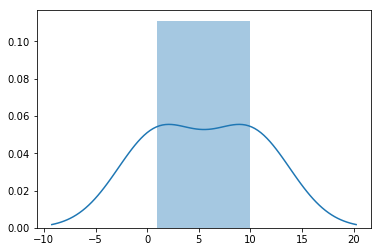

In [54]:
sns.distplot([i[1] for i in train if i[0]=='............'])

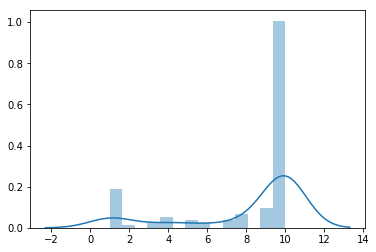

In [100]:
sns.distplot([i[1] for i in train if '10자' in i[0]])

In [106]:
[i for i in train if '-_-' in i[0]]

[['아 옛날이나 지금이나 지루한 영화 -_-', 2],
 ['최고!ac00477430 완전판은 좀-_-', 10],
 ['음악은 정말 감동적~ㅠ 둘이 안 엮어줘서 실망-_-', 7],
 ['2 엔딩에서의 예고편이 참..-_-;;', 10],
 ['"1편부터 6편까지 한번에 다봤네요, 그저그렇네요-_-"', 7],
 ['고냥 개쩜 -_-;;', 10],
 ['케빈 오늘도 너랑 노는 구나-_-', 10],
 ['꽤 재밌네요 -_-', 10],
 ['이 시리즈는 ac00887011게 나에게 별로다-_-', 5],
 ['아 ac01161235 mv00424801에 나온건지 오늘 처음 알았다-_-', 10],
 ['-_-)b 최고', 10],
 ['속편을 먼저 봤었는데 전편이 별로였는듯 했다 -_-;', 6],
 ['도대체 평점 1점 주는 초딩들은 뭐냐 -_-', 10],
 ['여주인공을바꿨으면 -_-', 10],
 ['대부완전대박!-_-', 10],
 ['아주 개명작이네 -_-... 대단ac00247936 꼭 보시길', 10],
 ['너무 졸려서-_-;;;;;;;;', 1],
 ['내가본 최고의 뮤지컬!! 별5개로 부족 -_-;;', 10],
 ['듣보잡 살리빠의 모차르트 죽이기 -_-ㅋㅋㅋ', 7],
 ['↓ 근데 평점이 왜 그러냐... -_-;', 10],
 ['줄곧 온몸에 뭐 묻혀서 난리치는 씬만..-_-;;', 5],
 ['-_- ac00502408 가는 기분으로 본 영화', 5],
 ['표절도 기술부족도 인정하는데 표절은 역사도 아닌가-_-', 10],
 ['전편은10점줄만ac00477430이건좀...-_-', 1],
 ['더스틴 호프먼 진짜 자폐증인줄 알았었다 -_-;;', 10],
 ['말도안나와..-_-', 1],
 ['오래된 영화는 흥미를 못느끼겠다는 -_-;', 5],
 ['-_-;;; 끝나고 나서의 당혹감을 감출수 없다.', 5],
 ['분위기는 느껴지는데 도데체가 산만해서-_-', 6],
 ['말이 필요없다..정말 최고 -_- 乃', 10],


In [90]:
cnt =0
for i in one:
    if(i[0] == "말이 필요없다."):
        print(cnt)
    else:
        cnt+=1
    

862
18057
46096


In [121]:
[i for i in one if '굿' in i[0]]

[['굿이네요', 1],
 ['완전 굿 !', 1],
 ['굿', 1],
 ['굿', 1],
 ['굿이네요', 1],
 ['굿', 1],
 ['굿', 1],
 ['굿', 1],
 ['굿', 1],
 ['굿', 1],
 ['좋음 굿.~', 1],
 ['와우 굿입니다 !!', 1],
 ['굿바이 평점...', 1],
 ['굿', 1],
 ['굿', 1],
 ['굿 ㅎ', 1],
 ['굿바이마이프렌드.', 1],
 ['굿', 1],
 ['굿~', 1],
 ['굿~~! 재밌음 평점균일성을 위해 별1개 ㅋ', 1],
 ['굿이다 굿!', 1],
 ['굿...그러나 10점은 좀.ㅡㅡ;', 1],
 ['굿!!!', 1],
 ['ㅋ굿', 1],
 ['알바가 아주 굿 굿 굿이에요 이거 알바하면 얼마줌??', 1],
 ['굿', 1],
 ['13살초딩도 웃을꺼갖다!굿ac01185190!!웃길수 있어요~', 1],
 ['굿', 1],
 ['ac01172353 굿', 1],
 ['굿..영화보는동안..눈을땔수가없다..또보고픔', 1],
 ['진짜 굿굿굿!!!!!!!!정말 잼있게 봤어요!', 1],
 ['스토리꽝 액션꽝. CG만 굿. 최악의 B급 영화.', 1],
 ['아주 굿이에요 굿굿굿굿 !!', 1],
 ['굿', 1],
 ['굿!!', 1],
 ['굿', 1],
 ['굿! 또  aldfnmv00074599님 초딩 무시?ㅡㅡ', 1],
 ['굿!~~~~~~~~~~~~', 1],
 ['배우는만보면 굿! 영화자체는 3류급..영화 감독책임..', 1],
 ['굿...우리 나라 cf 역사상...최고에..작품', 1],
 ['"배우들의 연기,씬,대사는 굿.설정 엉성,,알바땜시 1점"', 1],
 ['굿 그냥 1점 주고 싶어서^^', 1],
 ['굿', 1],
 ['감독 굿', 1],
 ['"굿,,,"', 1],
 ['굿 DVD로 빌려보는걸 추천', 1],
 ['굿', 1],
 ['굿', 1],
 ['굿', 1],
 ['와우 ^^ 팝콘 맛 음미하기엔 정말 굿', 1],
 ['정말 내 생에 

In [128]:
[i for i in one if '최고의 영화' in i[0]]

[['마지막에 울어버렸따 최고의 영화다...', 1],
 ['최고의 영화', 1],
 ['최고의 영화였다', 1],
 ['최고의 뮤직비디오지만 최고의 영화는 아님', 1],
 ['이 시대의 최고의 영화. 강추강추강추~!!!!!!', 1],
 ['최고의 영화는 mv00000340다~ 1위에서 내려오시지!', 1],
 ['내 최고의 영화', 1],
 ['내인생 최고의 영화', 1],
 ['세계 최고의 영화!', 1],
 ['최고의 영화다 ac00477430 평점은 너무 높다', 1],
 ['내인생 최고의 영화 ㅎㅎ', 1],
 ['아주 최고의 영화. -_-', 1],
 ['감히 최고의 영화', 1],
 ['내인생 최고의 영화..', 1],
 ['최고의 영화지만 찾아볼수가윖다 어딨는거냐 ㅂ느고싶다', 1],
 ['최고의 영화이다', 1],
 ['mv00172710년 최고의 영화입니다 꼭 봐야할 영화!', 1],
 ['"mv00060628,최고의 영화...."', 1],
 ['역시 최고의 영화다', 1],
 ['최고의 영화입니다!', 1],
 ['최고의 영화다 (물론 안봤음)', 1],
 ['진짜 재미있어여!!최고의 영화인듯~~^^', 1],
 ['너무 재밌고 감동적이다. 최고의 영화', 1],
 ['내 생에 최고의 영화 best 1위에 등극할뻔^^', 1],
 ['내인생최고의 영화', 1],
 ['내 생에 최고의 영화', 1],
 ['최고의 영화 추천합니다.ㅋㅋ', 1],
 ['최고의 영화중 일곱번째 영화', 1],
 ['어떤 의미에서는 내 인생 최고의 영화', 1],
 ['정말 재미있는 최고의 영화', 1],
 ['연기.구성.영상.감동 뭐하나 빠지지 않는 최고의 영화.', 1],
 ['최고의 영화!!', 1],
 ['내생애 최고의 영화', 1],
 ['내 생에 최고의 영화였습니다. 10점 주고싶군요 ^^', 1],
 ['정말 최고의 영화였다! -공포영화 진흥회', 1],
 ['최고의 영화.', 1],
 ['정말 최고의 영화다 단세포된기분 후후후후후 ~ ㅆㅂ', 1

In [107]:
one[3500:4500]

[['유치해서 10분보다 껐다.', 1],
 ['내 인생에서 극ac00319299 본 영화 중 mv00168784', 1],
 ['시스터액트2 카피한게 너무 많아..', 1],
 ['전 또 한번 보고 싶은데...', 1],
 ['머여..이게.. 개 씨부랄', 1],
 ['한국조폭 나오는거는 내용이 어쩌든 빵점 줘야해.', 1],
 ['말도 안되는 신파멜로..짜증나', 1],
 ['이거 영화 못보나?', 1],
 ['최악의 mv00277210 영화 ㅡㅡ', 1],
 ['끝까지 봤으면 후회했을꺼야', 1],
 ['너무 기대를 한거 같음 지루함.....', 1],
 ['난 좀 유치했다...8점 정도가 딱임', 1],
 ['진짜 지루하네...', 1],
 ['영화에 비해 평점이 높다 너무 매너리즘...', 1],
 ['이런 영화는 너무 많아서..', 1],
 ['솔직히 9점은 아니다.', 1],
 ['이건 영.....', 1],
 ['이건 ac00375937의 개미를 베낀거다.', 1],
 ['더 이상의 쓰레기는 없다', 1],
 ['먼저 나왔지만 아류작 평가 받은 ㅄ ㅋㅋㅋ', 1],
 ['베르베르 개미책 다 베낀거 소설이 훨씬 더 낫다.', 1],
 ['돈이아깝다 .. ac00500116만 볼만하다', 1],
 ['감흥도 느낌도 재미도 없었다', 1],
 ['단체 올누드라고 ac01436255팅만 요란했던 기억..', 1],
 ['이런영화 ac00906718에 너무 많아서 탈이었죠.다양성 무슨.', 1],
 ['이게 영화냐? 5분만에 딴 거 돌려버렸다', 1],
 ['까까먹자', 1],
 ['이게 잼있냐&gt;?', 1],
 ['아놔 알바들 ㅋㅋㅋ', 1],
 ['조국통일만만세', 1],
 ['내가 본 영화 최악의 리스트 mv00241276에 드는 영화', 1],
 ['최악!!', 1],
 ['재미없던데.. ㅡ.ㅡ;;', 1],
 ['1', 1],
 ['실망', 1],
 ['와 ac01203598 ac01472179봐 겁나 예쁘다', 1],
 ['기대를 많이 해서

In [131]:
candidate_one = [
"굿 ㅎ",
'정말최고의영화이다.',
'아주좋네요',
'재미있습니다 ㅎㅎㅎㅎ',
'mv00002482 이후에 오랜만에 감명깊게 본 액션대작.',
'조낸 훈훈하다',
'ㅋㅋ 개콘만큼 웃기다',
'재미있게 봤던기억이난다',
'감히 최고의 영화',
'아무생각없이 시간때우기는 그럭저럭 괜찮은 영화.',
'조국통일만만세',
'아주 최고의 영화. -_-',
'3등은 하기에는 무리가 9점 정도 될것 같음',
'좋은 영화',
'재미있네요',
'보고또봐도 최고..',
'영화잘봤습니다',
'mv00069166은 정말 좋은 영화였어요',
'애니메이션중 손꼽히는 수작입니다. 한번보세요 .',
'최고의 감동',
'재미있다.',
'ac00001858 만세!',
'최고임',
'좋아',
'멋지다',
'재밌다',
'진짜 잼 있는 영화다',
'최고최고최고최고!',
'최고',
'좋기는하네요',
'시간때우기엔 이딴 영화가 최고지!',
'여검사역의 ac01171534 섹시했는데 터질뻔했어',
'세계 최고의 영화!',
'최고다',
'정말 감동적, 사랑의 교훈이 느껴진다 10점!!',
'최고',
'재밌었따',
'good',
'재밌었어요 재미있게 봤습니당',
'기억에 남는군. 오~ 놀라운...',
'내인생 최고의 영화',
'저도 기대를 너무한듯 영화는 한 8점?',
'개인적으로 ac01447967의 목소리가 너무 좋았다.ㅎㅎ',
'점수너무높다.  최고의영화이긴했지만',
'진짜 재밌었던영화',
'명작이다',
'감사 감사',
'인생은 아름다우니깐요',
'내 최고의 영화',
'와우 굿입니다 !!',
'정말 재밌다. 5번도 더봤음.',
'너무 감동적 ㅠㅠ',
'멋진 영화네요.',
'보고또보고 최고임~!',
'이제야 봤지만.. 좋네..10점~^^',
'좋아 ㅋ',
'10월의 하늘이 최고다',
'좋음 굿.~',
'최고 짱재밌음',
'최고의명화~',
'재밌음',
'잼있음',
'재미있다',
'이 영화를 보고 암이 나았습니다',
'이건 1점이 아니다 11점을 주고 싶은 내마음이다',
'이건 1점이 아니다 11점을 주고 싶은 내마음이다.',
'내인생최고의영화ㅎㅎ',
'당시 엄청난 히트와 함께 나의 영웅이었던 형래형님',
'애는 썼는데 결과물은 기대이하다 7점이 적당',
'진짜 재밌음',
'소장은 했지만 잼없는 영화..7점이 적당..',
'ac01199065는 청순하게 이뿌다 ^-^',
'ac00000475의 매력적인 남성;; 그는 멋졌다..',
'너무 아름 답게본영화 아직도 감동이남아있습니다',
'짱',
'시대를 잘못만난 작품인듯!',
'참 좋은영화',
'볼만했다.',
'좋은 영화',
'프랑스영화중 단연으뜸',
'재밋네요',
'그냥 잘 만든 영화',
'멋지다 ac01426695.',
'끄으~ 취한다~',
'벤허가 최고',
'딥따 재밌내 작품성도 좋고',
'명작은 맞습니다.',
'재밋네',
'볼만한 영화임엔 틀림없습니다.',
'넘나재밋는것1234',
'쓸기',
'최고의영화! ..,,',
'디워는 여기에 비하면 새발의피임 정말 재밋음!',
'7점맞추자',
'영화 재밌어요',
'사실 7점',
'최고',
'추억의 명작',
'너무젬있어요!!',
'과대평가된 영화 8점이 적당..',
'좋음',
'진짜 최고의 감동!',
'감동...',
'질투나서 못 참겠어요! 너무 재밌으니까...',
'평점 8점정도면 적당할듯.. 9점ac01175227 개오버임',
'언제봐도 재밌다.',
'재밌고 유쾌하다',
'8.88',
'재밌다',
'괜찮아요. 볼만 함. 약간 과대평가...후회는 없음.',
'mv00385420 막연히 미국에대한 동경심을 키워줬던 영화',
'이거 정말 재미있는데',
'mv00133225 아주 섹시하다',
'역시 다세포 ㅋㅋㅋㅋㅋㅋㅋ',
'다세포가 대세다.',
'왜 갑자가 평점이 이렇게...',
'10점은 아니다,  7점정도',
'역시..말할수없는 비밀을 능가할영화는 없군하',
'재미있어요',
'한 8점이면 충분한 영화에.....',
'마지막에 울어버렸따 최고의 영화다...',
'볼만함.',
'브레이트하트가 최고임',
'꽤재밋엇음',
'재밌넹',
'훌륭ac00247936',
'굿이네요',
'종교인들한테 낚인듯...대단해..',
'완전 굿 !',
'갠찮네',
'굉장한 영화였습니다',
'재밌네요',
'mv00326635은 재미있고 감동적이에요',
'짱잼있는데 mv00069166이 더재미있다 ㅋㅋ',
'너무너무재미잇어요',
'굿',
'역시 1등급 영화죠. 1등급 ^^',
'오래오래 가시길... ㄷㄷ',
'와우',
'굿이네요',
'최고의 영화',
'best of best!',
'괜찮네 8점정도',
'야 기분조타',
'걸작 영상시..,,.',
'완전 재미있다.',
'최고',
'좋음',
'최고의 영화였다',
'말이 필요없다.',
    ]

In [132]:
'굿 ㅎ' in candidate_one

True

In [133]:
def irony_deleter(text,label):
    """
    output:
        bool : train with Trues and don't go with False
    """
    candidate_one = [
        "굿 ㅎ",
        '정말최고의영화이다.',
        '아주좋네요',
        '재미있습니다 ㅎㅎㅎㅎ',
        'mv00002482 이후에 오랜만에 감명깊게 본 액션대작.',
        '조낸 훈훈하다',
        'ㅋㅋ 개콘만큼 웃기다',
        '재미있게 봤던기억이난다',
        '감히 최고의 영화',
        '아무생각없이 시간때우기는 그럭저럭 괜찮은 영화.',
        '조국통일만만세',
        '아주 최고의 영화. -_-',
        '3등은 하기에는 무리가 9점 정도 될것 같음',
        '좋은 영화',
        '재미있네요',
        '보고또봐도 최고..',
        '영화잘봤습니다',
        'mv00069166은 정말 좋은 영화였어요',
        '애니메이션중 손꼽히는 수작입니다. 한번보세요 .',
        '최고의 감동',
        '재미있다.',
        'ac00001858 만세!',
        '최고임',
        '좋아',
        '멋지다',
        '재밌다',
        '진짜 잼 있는 영화다',
        '최고최고최고최고!',
        '최고',
        '좋기는하네요',
        '시간때우기엔 이딴 영화가 최고지!',
        '여검사역의 ac01171534 섹시했는데 터질뻔했어',
        '세계 최고의 영화!',
        '최고다',
        '정말 감동적, 사랑의 교훈이 느껴진다 10점!!',
        '최고',
        '재밌었따',
        'good',
        '재밌었어요 재미있게 봤습니당',
        '기억에 남는군. 오~ 놀라운...',
        '내인생 최고의 영화',
        '저도 기대를 너무한듯 영화는 한 8점?',
        '개인적으로 ac01447967의 목소리가 너무 좋았다.ㅎㅎ',
        '점수너무높다.  최고의영화이긴했지만',
        '진짜 재밌었던영화',
        '명작이다',
        '감사 감사',
        '인생은 아름다우니깐요',
        '내 최고의 영화',
        '와우 굿입니다 !!',
        '정말 재밌다. 5번도 더봤음.',
        '너무 감동적 ㅠㅠ',
        '멋진 영화네요.',
        '보고또보고 최고임~!',
        '이제야 봤지만.. 좋네..10점~^^',
        '좋아 ㅋ',
        '10월의 하늘이 최고다',
        '좋음 굿.~',
        '최고 짱재밌음',
        '최고의명화~',
        '재밌음',
        '잼있음',
        '재미있다',
        '이 영화를 보고 암이 나았습니다',
        '이건 1점이 아니다 11점을 주고 싶은 내마음이다',
        '이건 1점이 아니다 11점을 주고 싶은 내마음이다.',
        '내인생최고의영화ㅎㅎ',
        '당시 엄청난 히트와 함께 나의 영웅이었던 형래형님',
        '애는 썼는데 결과물은 기대이하다 7점이 적당',
        '진짜 재밌음',
        '소장은 했지만 잼없는 영화..7점이 적당..',
        'ac01199065는 청순하게 이뿌다 ^-^',
        'ac00000475의 매력적인 남성;; 그는 멋졌다..',
        '너무 아름 답게본영화 아직도 감동이남아있습니다',
        '짱',
        '시대를 잘못만난 작품인듯!',
        '참 좋은영화',
        '볼만했다.',
        '좋은 영화',
        '프랑스영화중 단연으뜸',
        '재밋네요',
        '그냥 잘 만든 영화',
        '멋지다 ac01426695.',
        '끄으~ 취한다~',
        '벤허가 최고',
        '딥따 재밌내 작품성도 좋고',
        '명작은 맞습니다.',
        '재밋네',
        '볼만한 영화임엔 틀림없습니다.',
        '넘나재밋는것1234',
        '쓸기',
        '최고의영화! ..,,',
        '디워는 여기에 비하면 새발의피임 정말 재밋음!',
        '7점맞추자',
        '영화 재밌어요',
        '사실 7점',
        '최고',
        '추억의 명작',
        '너무젬있어요!!',
        '과대평가된 영화 8점이 적당..',
        '좋음',
        '진짜 최고의 감동!',
        '감동...',
        '질투나서 못 참겠어요! 너무 재밌으니까...',
        '평점 8점정도면 적당할듯.. 9점ac01175227 개오버임',
        '언제봐도 재밌다.',
        '재밌고 유쾌하다',
        '8.88',
        '재밌다',
        '괜찮아요. 볼만 함. 약간 과대평가...후회는 없음.',
        'mv00385420 막연히 미국에대한 동경심을 키워줬던 영화',
        '이거 정말 재미있는데',
        'mv00133225 아주 섹시하다',
        '역시 다세포 ㅋㅋㅋㅋㅋㅋㅋ',
        '다세포가 대세다.',
        '왜 갑자가 평점이 이렇게...',
        '10점은 아니다,  7점정도',
        '역시..말할수없는 비밀을 능가할영화는 없군하',
        '재미있어요',
        '한 8점이면 충분한 영화에.....',
        '마지막에 울어버렸따 최고의 영화다...',
        '볼만함.',
        '브레이트하트가 최고임',
        '꽤재밋엇음',
        '재밌넹',
        '훌륭ac00247936',
        '굿이네요',
        '종교인들한테 낚인듯...대단해..',
        '완전 굿 !',
        '갠찮네',
        '굉장한 영화였습니다',
        '재밌네요',
        'mv00326635은 재미있고 감동적이에요',
        '짱잼있는데 mv00069166이 더재미있다 ㅋㅋ',
        '너무너무재미잇어요',
        '굿',
        '역시 1등급 영화죠. 1등급 ^^',
        '오래오래 가시길... ㄷㄷ',
        '와우',
        '굿이네요',
        '최고의 영화',
        'best of best!',
        '괜찮네 8점정도',
        '야 기분조타',
        '걸작 영상시..,,.',
        '완전 재미있다.',
        '최고',
        '좋음',
        '최고의 영화였다',
        '말이 필요없다.',
            ]
    if(label == 1):
        if "최고의 영화" in text:
            return False
        elif "굿" in text:
            return False
        elif text in candidate_one:
            return False
    return True

In [ ]:
# no train and do avg